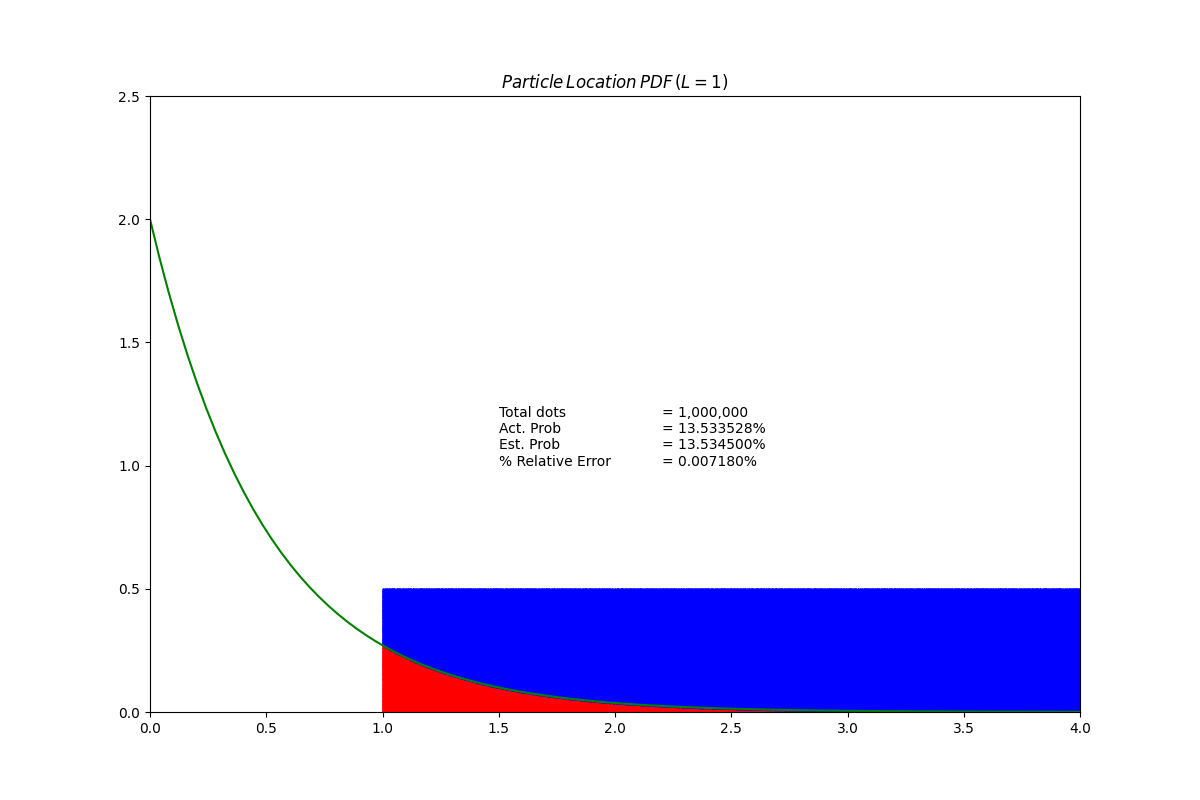

In [1]:
"""particle_location.ipynb"""
# Cell 1 - Using Monte Carlo method

# Used Dave's Code

from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Rectangle
from numba import float64, vectorize  # type: ignore

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget

# Defining a rectangular area where the particles will be distributed
sample_area = Rectangle((1, 0), 10, 0.5)

# Probability density function (PDF) for the particle distribution
def pdf(x: NDArray[np.float_]) -> NDArray[np.float_]:
    return np.array(2 * np.exp(-2 * x))

# Cumulative distribution function (CDF) for the particle distribution
def cdf(x: float) -> float:
    return -np.exp(-2 * x)

# Vectorized Halton sequence generator
@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h

# Function to plot the probability density function (PDF) of particle locations
def plot_pdf(ax: Axes) -> None:
    iterations = 1_000_000

    # Primes used in the Halton sequence generator
    primes: list[int] = [2, 3]

    # Generating particle locations in the sample area using Halton sequence
    x: NDArray[np.float_] = np.array(
        sample_area.get_x()
        + halton(np.arange(iterations), primes[0]) * sample_area.get_width()  # type: ignore
    )

    y: NDArray[np.float_] = (
        sample_area.get_y()
        + halton(np.arange(iterations), primes[1]) * sample_area.get_height()  # type: ignore
    )

    # Calculating the difference between the PDF and the generated y-coordinates
    d: NDArray[np.float_] = pdf(x) - y

    # Separating particles inside and outside the sample area
    x_in: NDArray[np.float_] = x[d >= 0.0]
    y_in: NDArray[np.float_] = y[d >= 0.0]

    x_out: NDArray[np.float_] = x[d < 0.0]
    y_out: NDArray[np.float_] = y[d < 0.0]

    # Calculating the pixel size for scatter plot markers
    pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore

    # Plotting particles inside and outside the sample area
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)

     # Plotting the actual probability density function (PDF)
    act_x: NDArray[np.float_] = np.linspace(0, 4, 100)
    act_y: NDArray[np.float_] = pdf(act_x)
    ax.plot(act_x, act_y, color="green")

    # Estimating the area under the PDF curve using Monte Carlo method
    est_area: float = (
        np.count_nonzero(d >= 0.0)
        / iterations
        * (sample_area.get_width() * sample_area.get_height())
    )

    # Calculating the actual area under the PDF curve
    act_area: float = cdf(sample_area.get_x() + sample_area.get_width()) - cdf(
        sample_area.get_x()
    )

    # Calculating the relative error between estimated and actual areas
    err: float = (est_area - act_area) / act_area

    # Setting plot title and axis limits
    ax.set_title(f"$Particle\,Location\,PDF\,(L=1)$")
    ax.set_xlim(0, 4.0)
    ax.set_ylim(0, 2.5)

     # Adding text to the plot to display total dots, actual and estimated probabilities, and relative error
    ax.text(1.5, 1.0, "Total dots\nAct. Prob\nEst. Prob\n% Relative Error", ha="left")

    ax.text(
        2.2,
        1.0,
        f"= {iterations:,}\n= {act_area:.6%}\n= {est_area:.6%}\n= {err:.6%}",
        ha="left",
    )

# Main function to create the plot and display it
def main() -> None:
    plt.close("all")
    plt.figure(" ", figsize=(12, 8))
    plot_pdf(plt.axes())
    plt.show()

# Calling the main function to generate the plot
main()

In [21]:
# Cell 2 - Using SciPy Integrate of PDF
# Used Dave's code

import scipy.integrate

# Using scipy.integrate.quad to calculate the area under the PDF curve from x=1 to x=100
area_scipy = scipy.integrate.quad(pdf, 1, 100)[0]

# Printing the calculated area, which represents the probability of particles being in the given range
print(f"Probability = {area_scipy:.6%}")


Probability = 13.533528%
